In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [16]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [17]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect= True)

In [18]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [19]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [21]:
# Find the most recent date in the data set. 
inspector = inspect(engine)
measurement_columns = inspector.get_columns("measurement")
for c in measurement_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [22]:
station_columns = inspector.get_columns("station")
for c in station_columns:
    print(c["name"],c["type"])

##now we know that the date column to query exists in the measurement table of the hawaii sqlite file

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [23]:
##most recent date is query the date; sort in descending order and pick first; in string fomat so still filters chronologically
most_recent_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

print(most_recent_date)


('2017-08-23',)


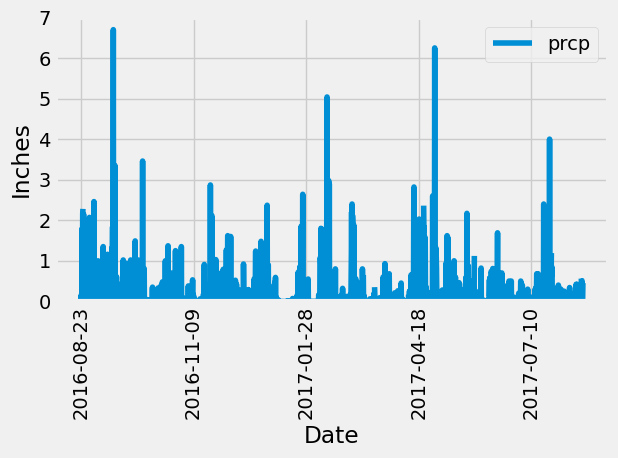

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

##variable start_date created into object from finding most_recent_date in cell above from Measurement class

values = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').\
    order_by(Measurement.date).all()

## Check to see if correct values were generated via for loop and printing values
## for value in values:
##     print(values)

# Calculate the date one year from the last date in data set.
    # value one year from the start date is 2016-08-23, by filtering for values greater than 2016-08-22 we include all days in that range


# Perform a query to retrieve the data and precipitation scores
    # query done for dates and precipitation and saved in the values variable above

# Save the query results as a Pandas DataFrame and set the index to the date column

values_df = pd.DataFrame(values)
values_final_df = values_df.set_index("date")
values_final_df

# Sort the dataframe by date
    ## date already sorted in ascending order since we queried the dates and precip and sorted when creating var "values"

# Use Pandas Plotting with Matplotlib to plot the data
values_final_df.plot()
plt.ylim(0,7)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.tight_layout()
plt.show()


In [25]:
# Use Pandas to calcualte the summary statistics for the precipitation data 

values_final_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [26]:
## Design a query to calculate the total number stations in the dataset 

total_number_stations= session.query(Station.station).count()
total_number_stations


9

In [27]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
    order_by(func.count(Measurement.station).desc()).\
    group_by(Measurement.station).all() 

print(active_stations) 

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [28]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature. 
## Most active station would be the first in a descending list of measurement station count - Station: USC00519281

most_active_station = session.query(Measurement.station,func.count(Measurement.station)).\
    order_by(func.count(Measurement.station).desc()).\
    group_by(Measurement.station).first()

## Check to see if most active station was selected:
## print(most_active_station) 

## Isolate station number from this list of station numbers and count of stations
most_active_station_number = most_active_station[0]
most_active_station_number 

## Lowest temperature for most active station
lowest_temperature = session.query(func.min(Measurement.tobs)).\
  filter(Measurement.station==most_active_station_number).all()
print(lowest_temperature) 

## print(f"The lowest temperature for station {lowest_temperature}")

## Highest temperature for most active station
highest_temperature = session.query(func.max(Measurement.tobs)).\
  filter(Measurement.station==most_active_station_number).all()

print(highest_temperature)

## Avg temperature for most active station
average_temperature = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station==most_active_station_number).all()

print(average_temperature)

[(54.0,)]
[(85.0,)]
[(71.66378066378067,)]


(0.0, 70.0)

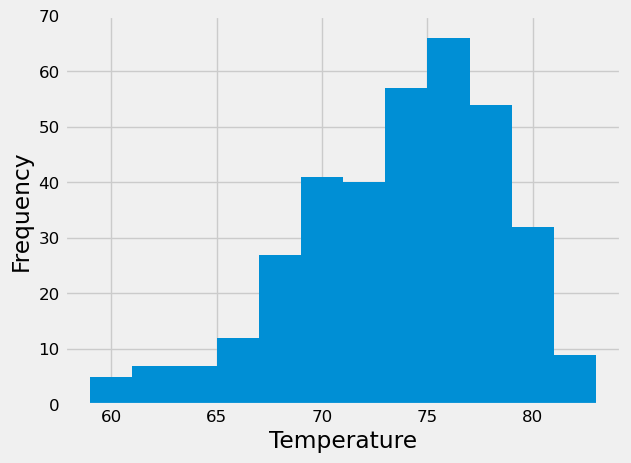

In [30]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

## Find most recent date for Station: USC00519281 in the Measurement table

most_recent_date_station = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.station == most_active_station_number).\
    order_by(Measurement.date.desc()).first()

## Found that 2017-08-18' is the most recent date for temp obeserved for most active station: USC00519281, tobs: 79

## Create query saying to find dates 12 months before 2017-08-08 (thus > 2016-08-08), for our most active station
twelve_month_values = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.station == most_active_station_number).\
    filter(Measurement.date > '2016-08-17').all()

## Check to see if values appear correctly
## for value in twelve_month_values:
##     print(value)

## Plot
## Create series with just tobs from this 12 month period 
twelve_month_tobs_values_df = pd.DataFrame(twelve_month_values)["tobs"]
twelve_month_tobs_values_df 

hist = twelve_month_tobs_values_df.hist(bins=12) 
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,70)


# Close session

In [31]:
# Close Session
session.close()